## 6.3 배치 정규화

배치 정규화의 장점

- 학습을 빠르게 진행할 수 있다. (학습 속도 개선)
- 초깃값에 크게 의존하지 않는다. (초깃값 선택 고민을 줄여준다.)
- 오버피팅을 억제한다. (드롭아웃 필요성 감소)

Why?) 정규화를 통해 각 hidden layer에서 입력데이터의 분포가 일정하게 되고, learning rate를 크게 설정해도 괜찮다. 결과적으로 학습속도가 빨라지게 된다. 

<img src= "https://i.imgur.com/Tpcfiw4.png" width=600>

배치 정규화는 각 층의 활성화 함수의 앞에 **배치 정규화 계층(batch norm)**을 넣어, 각 층에서 학습 시 각 미니배치를 단위로 평균이 0, 분산이 1이 되도록 정규화한다.

<img src= "https://i.imgur.com/NiyHN7u.png" width=300>

이 때 **ε**은 0으로 나누는 경우를 예방한다.

<img src= "https://i.imgur.com/Ef7P0KX.png" width=150>

또한 **배치 정규화 계층(batch norm)**마다 정규화 시킨 데이터에 확대와 이동 변환을 수행한다. **γ**는 확대 변환을, **β**는 이동 변환을 담당하는 parameter이며, 학습하면서 적합한 parameter로 조정한다.

<img src= "https://i.imgur.com/7diLWkV.png" width=700>

배치 정규화 과정을 계산 그래프로 나타내면 위와 같다.

In [13]:
class BatchNormalization:
    
    def __init__(self, gamma, beta, momentum=0.9, running_mean=None, running_var=None):
        self.gamma = gamma
        self.beta = beta
        self.momentum = momentum
        self.input_shape = None # 합성곱 계층은 4차원, 완전연결 계층은 2차원  

        # 시험할 때 사용할 평균과 분산
        self.running_mean = running_mean
        self.running_var = running_var  
        
        # backward 시에 사용할 중간 데이터
        self.batch_size = None
        self.xc = None
        self.std = None
        self.dgamma = None
        self.dbeta = None

    def forward(self, x, train_flg=True):
        self.input_shape = x.shape
        if x.ndim != 2:
            N, C, H, W = x.shape
            x = x.reshape(N, -1)

        out = self.__forward(x, train_flg)
        
        return out.reshape(*self.input_shape)
            
    def __forward(self, x, train_flg):
        if self.running_mean is None:
            N, D = x.shape
            self.running_mean = np.zeros(D)
            self.running_var = np.zeros(D)
                        
        if train_flg:
            mu = x.mean(axis=0)
            xc = x - mu
            var = np.mean(xc**2, axis=0)
            std = np.sqrt(var + 10e-7)
            xn = xc / std
            
            self.batch_size = x.shape[0]
            self.xc = xc
            self.xn = xn
            self.std = std
            self.running_mean = self.momentum * self.running_mean + (1-self.momentum) * mu
            self.running_var = self.momentum * self.running_var + (1-self.momentum) * var            
        else:
            xc = x - self.running_mean
            xn = xc / ((np.sqrt(self.running_var + 10e-7)))
            
        out = self.gamma * xn + self.beta # gamma와 beta를 받아서 학습값을 조정
        return out

    def backward(self, dout):
        if dout.ndim != 2:
            N, C, H, W = dout.shape
            dout = dout.reshape(N, -1)

        dx = self.__backward(dout)

        dx = dx.reshape(*self.input_shape)
        return dx

    def __backward(self, dout):
        dbeta = dout.sum(axis=0)
        dgamma = np.sum(self.xn * dout, axis=0)
        dxn = self.gamma * dout
        dxc = dxn / self.std
        dstd = -np.sum((dxn * self.xc) / (self.std * self.std), axis=0)
        dvar = 0.5 * dstd / self.std
        dxc += (2.0 / self.batch_size) * self.xc * dvar
        dmu = np.sum(dxc, axis=0)
        dx = dxc - dmu / self.batch_size
        
        self.dgamma = dgamma # gamma값 업데이트
        self.dbeta = dbeta # beta값 업데이트
        
        return dx

## 6.4 오버피팅의 억제

오버피팅이 일어나는 환경

- 매개변수가 많고 표현력이 높은 모델을 사용하는 경우 (Deep learning의 경우에는 신경망의 층을 깊게 만드는 경우)
- Training data가 적은 경우

In [68]:
import os
import sys

sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD
from common.trainer import Trainer
from common.util import shuffle_dataset

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

In [69]:
# 오버피팅을 재현하기 위해 의도적으로 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

In [17]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # learning rate가 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

In [18]:
for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.07, test acc:0.1045
epoch:1, train acc:0.08666666666666667, test acc:0.1154
epoch:2, train acc:0.10666666666666667, test acc:0.121
epoch:3, train acc:0.12333333333333334, test acc:0.1299
epoch:4, train acc:0.15333333333333332, test acc:0.1426
epoch:5, train acc:0.17666666666666667, test acc:0.1577
epoch:6, train acc:0.21333333333333335, test acc:0.173
epoch:7, train acc:0.25666666666666665, test acc:0.1922
epoch:8, train acc:0.2866666666666667, test acc:0.2098
epoch:9, train acc:0.2966666666666667, test acc:0.2209
epoch:10, train acc:0.32, test acc:0.2362
epoch:11, train acc:0.32, test acc:0.236
epoch:12, train acc:0.36666666666666664, test acc:0.2595
epoch:13, train acc:0.37, test acc:0.2766
epoch:14, train acc:0.4033333333333333, test acc:0.3023
epoch:15, train acc:0.4166666666666667, test acc:0.3067
epoch:16, train acc:0.4533333333333333, test acc:0.341
epoch:17, train acc:0.4633333333333333, test acc:0.3631
epoch:18, train acc:0.49, test acc:0.3794
epoch:19, tr

epoch:164, train acc:1.0, test acc:0.7438
epoch:165, train acc:1.0, test acc:0.7435
epoch:166, train acc:1.0, test acc:0.7444
epoch:167, train acc:1.0, test acc:0.7433
epoch:168, train acc:1.0, test acc:0.7446
epoch:169, train acc:1.0, test acc:0.7414
epoch:170, train acc:1.0, test acc:0.7438
epoch:171, train acc:1.0, test acc:0.744
epoch:172, train acc:1.0, test acc:0.7422
epoch:173, train acc:1.0, test acc:0.742
epoch:174, train acc:1.0, test acc:0.7443
epoch:175, train acc:1.0, test acc:0.7441
epoch:176, train acc:1.0, test acc:0.7435
epoch:177, train acc:1.0, test acc:0.7434
epoch:178, train acc:1.0, test acc:0.7434
epoch:179, train acc:1.0, test acc:0.743
epoch:180, train acc:1.0, test acc:0.7432
epoch:181, train acc:1.0, test acc:0.7441
epoch:182, train acc:1.0, test acc:0.7442
epoch:183, train acc:1.0, test acc:0.7431
epoch:184, train acc:1.0, test acc:0.7433
epoch:185, train acc:1.0, test acc:0.7457
epoch:186, train acc:1.0, test acc:0.7449
epoch:187, train acc:1.0, test acc:0.

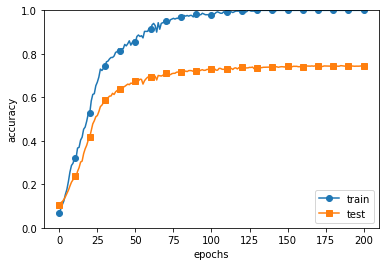

In [19]:
# 그래프
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

위의 결과를 확인하면, training data의 accuracy가 거의 1.0(100%)에 도달한 반면에, test data의 accuracy는 이를 따라가지 못하는 것을 볼 수 있다.

### 가중치 감소(weight decay)

: 학습 과정(parameter update)에서 큰 가중치에 대해서는 그 양에 해당하는 큰 페널티를 부과하여 오버피팅을 억제하는 방법.

신경망 학습의 목적인 loss fuction의 값을 줄이는 것이다. 이 때 loss fuction에 가중치의 **L2 norm**을 더하게 되면, loss fuction의 값을 줄이는 과정에서 가중치가 커지는 것을 억제할 수 있다. 각각의 loss function에

$$\frac { 1 }{ 2 } \lambda { W }^{ 2 }$$

을 더하여 가중치의 크기에 대한 페널티를 부여한다. $\lambda$(lambda)는 정규화의 세기를 조절하는 hyperparameter이다.

In [15]:
def loss(self, x, t, train_flg=False):
        """손실 함수를 구한다.
        
        Parameters
        ----------
        x : 입력 데이터
        t : 정답 레이블 
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):
            W = self.params['W' + str(idx)] # 각 hidden layer의 weight를 저장
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2) # 저장된 hidden layer의 weight들을 제곱하고, lambda를 곱한다.

        return self.last_layer.forward(y, t) + weight_decay # weight_decay를 loss함수에 더한다.

weight decay를 사용하면 실제로 overfitting이 해소되는지 살펴본다.

In [20]:
# weight decay 설정
weight_decay_lambda = 0.1

In [31]:
network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

In [22]:
for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

epoch:0, train acc:0.10666666666666667, test acc:0.088
epoch:1, train acc:0.11, test acc:0.0895
epoch:2, train acc:0.10666666666666667, test acc:0.0916
epoch:3, train acc:0.11333333333333333, test acc:0.0939
epoch:4, train acc:0.12, test acc:0.0992
epoch:5, train acc:0.12333333333333334, test acc:0.1025
epoch:6, train acc:0.13333333333333333, test acc:0.1107
epoch:7, train acc:0.14333333333333334, test acc:0.1164
epoch:8, train acc:0.14333333333333334, test acc:0.1235
epoch:9, train acc:0.16, test acc:0.1303
epoch:10, train acc:0.17666666666666667, test acc:0.1353
epoch:11, train acc:0.17666666666666667, test acc:0.1337
epoch:12, train acc:0.18333333333333332, test acc:0.1341
epoch:13, train acc:0.18333333333333332, test acc:0.1351
epoch:14, train acc:0.20333333333333334, test acc:0.1427
epoch:15, train acc:0.20666666666666667, test acc:0.15
epoch:16, train acc:0.23, test acc:0.1603
epoch:17, train acc:0.25666666666666665, test acc:0.1685
epoch:18, train acc:0.26, test acc:0.168
epoch:

epoch:162, train acc:0.81, test acc:0.6596
epoch:163, train acc:0.81, test acc:0.6511
epoch:164, train acc:0.8133333333333334, test acc:0.6448
epoch:165, train acc:0.82, test acc:0.6522
epoch:166, train acc:0.8066666666666666, test acc:0.6525
epoch:167, train acc:0.7933333333333333, test acc:0.6582
epoch:168, train acc:0.8166666666666667, test acc:0.6648
epoch:169, train acc:0.8133333333333334, test acc:0.6674
epoch:170, train acc:0.8133333333333334, test acc:0.658
epoch:171, train acc:0.8133333333333334, test acc:0.6588
epoch:172, train acc:0.8166666666666667, test acc:0.6664
epoch:173, train acc:0.8133333333333334, test acc:0.6559
epoch:174, train acc:0.81, test acc:0.6586
epoch:175, train acc:0.8033333333333333, test acc:0.652
epoch:176, train acc:0.8033333333333333, test acc:0.6519
epoch:177, train acc:0.81, test acc:0.645
epoch:178, train acc:0.8133333333333334, test acc:0.6535
epoch:179, train acc:0.8233333333333334, test acc:0.6627
epoch:180, train acc:0.8, test acc:0.6572
epoch

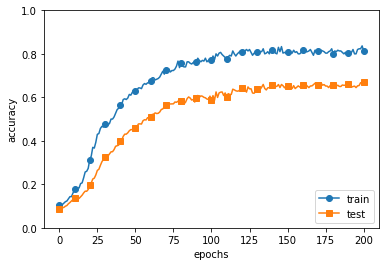

In [23]:
# 그래프
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

위의 결과를 확인하면, training data와 test data에 대한 정확도의 차이가 줄어든 것을 확인할 수 있고, training data의 accuracy가 완전히 1.0(100%)에 도달하지 못한 점을 확인할 수 있다.

### 드롭 아웃(Dropout)
: 뉴런을 임의로 삭제하면서 학습하는 방법. Training 때, hidden layer의 뉴런을 무작위로 골라 삭제하면서 학습한다. 즉 각 출력에서 일정한 부위에서의 신호의 전달을 차단한다.

<img src= "https://i.imgur.com/Hin1BWM.png" width=500>

In [24]:
class Dropout:

    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio 
            # hidden layer와 크기가 같은 배열을 무작위로 생성하여, 그 값이 dropout_ratio보다 작은 node는 False로 설정하여 drop시킨다.
            return x * self.mask 
            # self.mask와 input을 곱하면, drop된 node는 계산에 사용되지 않는다.
        else:
            return x * (1.0 - self.dropout_ratio)

    def backward(self, dout):
        return dout * self.mask

dropout을 사용하면 실제로 overfitting이 해소되는지 살펴본다.

In [70]:
# 드롭아웃 사용 유무와 비율 설정
use_dropout = True
dropout_ratio = 0.2

In [71]:
network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], 
                              output_size=10, use_dropout=True, dropout_ration=0.2)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

train loss:2.323762013080246
=== epoch:1, train acc:0.08333333333333333, test acc:0.1053 ===
train loss:2.3023489060211055
train loss:2.300578945424215
train loss:2.290620596242969
=== epoch:2, train acc:0.08, test acc:0.1066 ===
train loss:2.308906470010802
train loss:2.302558282621394
train loss:2.3182360811845997
=== epoch:3, train acc:0.08, test acc:0.1066 ===
train loss:2.299709750834534
train loss:2.3098915451925692
train loss:2.2832396593108215
=== epoch:4, train acc:0.07333333333333333, test acc:0.1073 ===
train loss:2.2984168277486265
train loss:2.2997288456816314
train loss:2.3056230724158997
=== epoch:5, train acc:0.07666666666666666, test acc:0.1088 ===
train loss:2.3055779950557236
train loss:2.3073174576552504
train loss:2.2943257117744427
=== epoch:6, train acc:0.07666666666666666, test acc:0.1087 ===
train loss:2.321798212177259
train loss:2.2977232061213457
train loss:2.313796115032889
=== epoch:7, train acc:0.07333333333333333, test acc:0.1098 ===
train loss:2.2852595

=== epoch:57, train acc:0.24333333333333335, test acc:0.2111 ===
train loss:2.216889929321017
train loss:2.2086282475006005
train loss:2.2238839694479573
=== epoch:58, train acc:0.26, test acc:0.2213 ===
train loss:2.2283343042674377
train loss:2.1982151869259074
train loss:2.203875091667029
=== epoch:59, train acc:0.26, test acc:0.2262 ===
train loss:2.206117280994626
train loss:2.200395882594824
train loss:2.2141819910504217
=== epoch:60, train acc:0.2633333333333333, test acc:0.2295 ===
train loss:2.2184994003301757
train loss:2.2023963035207283
train loss:2.2134967473653147
=== epoch:61, train acc:0.2633333333333333, test acc:0.2371 ===
train loss:2.2028278187936228
train loss:2.2046555083059323
train loss:2.2144059057425727
=== epoch:62, train acc:0.2633333333333333, test acc:0.2362 ===
train loss:2.205295550292366
train loss:2.1848412448534953
train loss:2.228420590081786
=== epoch:63, train acc:0.26, test acc:0.2325 ===
train loss:2.2046308671353416
train loss:2.169792911194348


=== epoch:113, train acc:0.3566666666666667, test acc:0.2955 ===
train loss:2.0334255709305653
train loss:2.065040417844468
train loss:2.0061054524754893
=== epoch:114, train acc:0.35333333333333333, test acc:0.2943 ===
train loss:2.015009492255508
train loss:1.995506686764369
train loss:2.0086473427107587
=== epoch:115, train acc:0.35333333333333333, test acc:0.2947 ===
train loss:1.9888549175106423
train loss:1.970552999098839
train loss:2.0834979267589557
=== epoch:116, train acc:0.35, test acc:0.2942 ===
train loss:2.0683297639917217
train loss:2.026720170657071
train loss:2.0101382365541247
=== epoch:117, train acc:0.35, test acc:0.2958 ===
train loss:1.9909826300526767
train loss:2.075430398503011
train loss:2.1142092496683347
=== epoch:118, train acc:0.3566666666666667, test acc:0.298 ===
train loss:1.9626703646860133
train loss:2.071719095953297
train loss:1.982861304220828
=== epoch:119, train acc:0.3566666666666667, test acc:0.2986 ===
train loss:1.927284647676846
train loss:

=== epoch:168, train acc:0.42, test acc:0.329 ===
train loss:1.7641651764703326
train loss:1.8424435035901385
train loss:1.796890194675882
=== epoch:169, train acc:0.42333333333333334, test acc:0.3307 ===
train loss:1.8207761621112744
train loss:1.7137931024240984
train loss:1.7027172619686874
=== epoch:170, train acc:0.42333333333333334, test acc:0.3308 ===
train loss:1.816264314094005
train loss:1.7257345947853897
train loss:1.8455503677592051
=== epoch:171, train acc:0.4266666666666667, test acc:0.3337 ===
train loss:1.7230223942285425
train loss:1.7842951950386299
train loss:1.825948147732555
=== epoch:172, train acc:0.4266666666666667, test acc:0.3341 ===
train loss:1.7085024109986842
train loss:1.6986791719639336
train loss:1.7839125773113471
=== epoch:173, train acc:0.43, test acc:0.3345 ===
train loss:1.8067225705108871
train loss:1.7918011358798254
train loss:1.7648662082880735
=== epoch:174, train acc:0.43333333333333335, test acc:0.3359 ===
train loss:1.775133580864636
train

=== epoch:223, train acc:0.51, test acc:0.3918 ===
train loss:1.4674646357228591
train loss:1.529634087162373
train loss:1.5354930186843583
=== epoch:224, train acc:0.5066666666666667, test acc:0.3893 ===
train loss:1.6986118256989744
train loss:1.4658852951628856
train loss:1.6858361356497795
=== epoch:225, train acc:0.51, test acc:0.3923 ===
train loss:1.38503627980676
train loss:1.5631879050361106
train loss:1.4516559161896105
=== epoch:226, train acc:0.5, test acc:0.3892 ===
train loss:1.612591225640986
train loss:1.5455041943331693
train loss:1.638435893028681
=== epoch:227, train acc:0.51, test acc:0.3943 ===
train loss:1.6666641728487748
train loss:1.5471775683599696
train loss:1.6087627683128602
=== epoch:228, train acc:0.5233333333333333, test acc:0.3999 ===
train loss:1.4580163267046735
train loss:1.654558029172143
train loss:1.6588532348716571
=== epoch:229, train acc:0.5333333333333333, test acc:0.4019 ===
train loss:1.4278074443827415
train loss:1.524957345507581
train los

=== epoch:279, train acc:0.64, test acc:0.4978 ===
train loss:1.2541615916454285
train loss:1.2379115836251102
train loss:1.200599553748501
=== epoch:280, train acc:0.6433333333333333, test acc:0.4974 ===
train loss:1.2911466312121964
train loss:1.2870235418404503
train loss:1.2794616114166057
=== epoch:281, train acc:0.6433333333333333, test acc:0.4979 ===
train loss:1.3626399513621879
train loss:1.334256309559863
train loss:1.3658479204175265
=== epoch:282, train acc:0.66, test acc:0.5027 ===
train loss:1.25644611821099
train loss:1.4002354058347342
train loss:1.2171245412777394
=== epoch:283, train acc:0.6566666666666666, test acc:0.5058 ===
train loss:1.1516030844668783
train loss:1.0757136238200216
train loss:1.3874529571305265
=== epoch:284, train acc:0.65, test acc:0.5054 ===
train loss:1.190040060135139
train loss:1.4524737312122433
train loss:1.2605730400290682
=== epoch:285, train acc:0.6533333333333333, test acc:0.5088 ===
train loss:1.2910654371911034
train loss:1.146468229

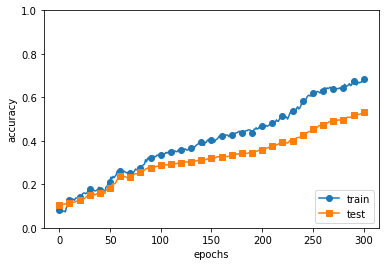

In [72]:
# 그래프
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## 6.5 hyperparameter 효율적으로 조정하기

### Validation data를 미리 분리하기

: **Validation data**를 Training data로부터 미리 분리하여, hyperparameter를 조정할 때 사용한다.

### hyperparameter 최적화

: hyperparameter의 **최적 값**이 존재할 수 있는 **범위**를 조금씩 줄여나가는 방법. 대략적인 범위를 설정한 뒤에 무작위로 hyperparameter의 값을 **sampling**한 후, 정확도를 평가한다. 이러한 작업을 여러 번 반복하여 hyperparameter의 **최적 값**의 범위를 좁혀간다.

1. hyperparameter의 값의 범위를 설정한다. (10의 거듭제곱 단위, **log scale**로 지정한다.)

2. 설정된 범위에서 hyperparameter의 값을 무작위로 sampling한다.

3. 2단계에서 sampling한 hyperparameter의 값을 사용하여 학습하고, validation data로 정확도를 평가한다.

4. 2~3단계를 임의의 횟수만큼 반복하여, 그 정확도를 보고 hyperparameter의 범위를 수정한다.

In [63]:
# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

In [64]:
def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list

In [65]:
# hyperparameter 무작위 탐색
optimization_trial = 100 # 100번 시도
results_val = {}
results_train = {}

for _ in range(optimization_trial):
    # 탐색한 hyperparameter 범위 지정
    weight_decay = 10 ** np.random.uniform(-8, -4) # weight decay의 값 범위 지정
    lr = 10 ** np.random.uniform(-6, -2) # learning rate의 값 범위 지정

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

val acc:0.34 | lr:0.002141363879356653, weight decay:2.2490721709461877e-06
val acc:0.14 | lr:1.0119319130575426e-06, weight decay:2.4945805735901177e-08
val acc:0.11 | lr:9.011177375422073e-05, weight decay:2.2517081693222797e-08
val acc:0.16 | lr:7.758060058145069e-05, weight decay:9.868714967512577e-05
val acc:0.12 | lr:1.4730512991225995e-06, weight decay:2.4427424009176462e-05
val acc:0.11 | lr:2.0236860593784194e-05, weight decay:1.3941279338956343e-08
val acc:0.13 | lr:2.8549150966122274e-05, weight decay:1.272283259657272e-05
val acc:0.14 | lr:0.001227825818158986, weight decay:9.472718930339805e-07
val acc:0.64 | lr:0.003000752027899676, weight decay:2.921527565735996e-05
val acc:0.39 | lr:0.003025156271310908, weight decay:2.4217396742361944e-05
val acc:0.15 | lr:8.617549499567187e-05, weight decay:1.7104837515173504e-06
val acc:0.87 | lr:0.008377781813198386, weight decay:2.065295037992613e-05
val acc:0.09 | lr:6.575117454056138e-05, weight decay:2.0634527215246604e-08
val a

=========== Hyper-Parameter Optimization Result ===========
Best-1(val acc:0.21666666666666667) | lr:0.002136607345722235, weight decay:6.989964703719477e-05
Best-2(val acc:0.2) | lr:0.00026697338402540484, weight decay:2.8231344268370967e-06
Best-3(val acc:0.18333333333333332) | lr:2.0748334394750932e-05, weight decay:1.3267261790301825e-07
Best-4(val acc:0.16666666666666666) | lr:0.000763347555854404, weight decay:2.992099694019752e-08
Best-5(val acc:0.16666666666666666) | lr:0.0007082352007704818, weight decay:1.3016784006933229e-05
Best-6(val acc:0.16666666666666666) | lr:0.001919702618873146, weight decay:2.1077937325467582e-07
Best-7(val acc:0.16666666666666666) | lr:0.006374972469953048, weight decay:3.235118657737735e-06
Best-8(val acc:0.16666666666666666) | lr:2.069845031275795e-06, weight decay:2.8428444489931127e-08
Best-9(val acc:0.15) | lr:2.5844078528463455e-06, weight decay:8.168184509744596e-06
Best-10(val acc:0.15) | lr:7.915701095744678e-06, weight decay:4.59610687575

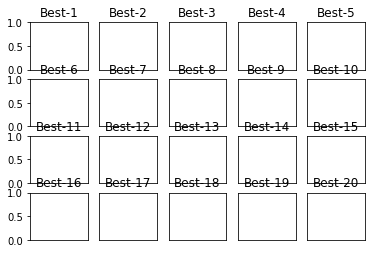

In [61]:
# 그래프
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()